## Laden der Text Daten 

In [28]:
import os, gzip
import pandas as pd
import numpy as np
import urllib.request

DATADIR = "data"

if not os.path.exists(DATADIR): 
    os.mkdir(DATADIR)

file_name = os.path.join(DATADIR, 'bundestags_parlamentsprotokolle.csv.gzip')
if not os.path.exists(file_name):
    url_data = 'https://www.dropbox.com/s/1nlbfehnrwwa2zj/bundestags_parlamentsprotokolle.csv.gzip?dl=1'
    urllib.request.urlretrieve(url_data, file_name)

df = pd.read_csv(gzip.open(file_name)).sample(frac=1)

print("{} Reden wurden geladen".format(len(df)))

# Zeige einige Reden von Parteien
for party in np.unique(df['partei']):
    print("\n****************************\nBeispiele von Partei {}:\n****************************\n".format(party))
    for _, speech in df[df['partei']==party].sample(2).iterrows():
        print("\n*******************************\nSprecher {}:\n\n{}".format(speech['sprecher'], speech['text']))


43679 Reden wurden geladen

****************************
Beispiele von Partei cducsu:
****************************


*******************************
Sprecher Nadine Schön:

Liebe Kolleginnen und Kollegen, mit den Regelungen, die wir heute verabschieden, wollen wir die Kommunen und die Anbieter bei ihren Bemühungen unterstützen. Wir schaffen mit dem heutigen Gesetz mehr Transparenz, mehr Verbindlichkeit und mehr Sicherheit.

Die wichtigsten Punkte haben die Kollegen bereits genannt. Ich will nur kurz auf die Änderungsanträge der Koalition eingehen. Zum einen wollen wir alternative Infrastrukturen für den Breitbandausbau öffnen. Alternative Infrastrukturen sind Wasserkanäle, Energieleitungen und Kabelkanäle. Wenn es keine Einigung mit dem Eigentümer gibt, dann findet ein Schlichtungsverfahren statt. Ich denke, das ist eine pragmatische Lösung.

Einen Schritt weiter gehen wir dort, wo wir selbst Verantwortung tragen, nämlich beim Bund. Bei Bundesstraßen, Eisenbahn und Bundeswasserstraßen 

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import warnings

def train(texts, party):
    '''
    Eine Funktion, die gegeben Texte und Labels einen Klassifier trainiert
    '''
    stopwords = [w.strip() for w in open("data/stopwords.txt").readlines()]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Eine Machine Learning Pipeline um Bag-of-Words Vectors zu erstellen aus Texten
        text_clf = Pipeline([('vect', TfidfVectorizer(stop_words=stopwords)),
                            ('clf', SGDClassifier(loss='log', class_weight='balanced'))])
        # some hyperparameters
        parameters = {
            'vect__ngram_range': [(1, 1), (1, 2)],
            'vect__max_df': [0.8],
            'clf__alpha': (np.logspace(-6, -4, 2)).tolist()
        }
        # perform gridsearch to get the best regularizer
        clf = GridSearchCV(text_clf, parameters, cv=2, n_jobs=-1,verbose=4)
        clf.fit(texts, party)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_estimator_)
        print()
        print("Grid scores on development set:")
        print()
        for params, mean_score, scores in clf.grid_scores_:
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean_score, scores.std() / 2, params))
        print()


    return clf


## Trainieren eines linearen Klassifiers

In [98]:
# Erst nehmen wir einige Daten beiseite, um das Model darauf spaeter testen zu koennen
idx = df.wahlperiode == 18
train_data, test_data, train_labels, test_labels = train_test_split(df['text'][idx], df['partei'][idx], test_size=0.3)

# Jetzt trainieren wir den Klassifier
clf = train(train_data, train_labels)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1) ....
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1) ....
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 2) ....
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 2) ....
[CV]  clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.5156183140778776, total=   8.9s
[CV]  clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.5249572162007986, total=   9.3s
[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1) ...
[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1) ...
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.5365088419851682, total=   9.0s
[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2) ...
[CV]  clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 2), score=0.5382201939532231, total=  21.6s
[CV]  clf__

[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   34.0s remaining:   34.0s


[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2) ...
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.5430038510911425, total=  10.2s
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2), score=0.5195379349686252, total=  15.5s
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2), score=0.5338753387533876, total=  14.7s


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   54.1s finished


Best parameters set found on development set:

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

Grid scores on development set:

0.520 (+/-0.002) for {'clf__alpha': 1e-06, 'vect__max_df': 0.8, 'vect__ngram_range': (1, 1)}
0.537 (+/-0.001) for {'clf__alpha': 1e-06, 'vect__max_df': 0.8, 'vect__ngram_range': (1, 2)}
0.540 (+/-0.002) for {'clf__alpha': 0.0001, 'vect__max_df': 0.8, 'vect__ngram_range': (1, 1)}
0.527 (+/-0.004) for {'clf__alpha': 0.0001, 'vect__max_df': 0.8, 'vect__ngram_range': (1, 2)}



# Vorhersage auf Trainings Daten

In [97]:
train_predictions = clf.predict(train_data)
report = classification_report(train_predictions, train_labels)
print(report)

             precision    recall  f1-score   support

     cducsu       0.94      0.57      0.71      8845
        fdp       0.00      0.00      0.00         0
     gruene       0.50      0.80      0.61      1608
      linke       0.67      0.74      0.70      2281
        spd       0.56      0.71      0.63      3214

avg / total       0.78      0.65      0.68     15948



/Users/felix/Code/Python/ml-schule/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Vorhersage auf Test Daten

In [32]:
test_predictions = clf.predict(test_data)
report = classification_report(test_predictions, test_labels)
print(report)

             precision    recall  f1-score   support

     cducsu       0.84      0.60      0.70      3535
     gruene       0.31      0.60      0.41       476
      linke       0.48      0.60      0.53       692
        spd       0.41      0.53      0.47      1308

avg / total       0.66      0.58      0.60      6011



## Confusion Matrix

In [33]:
print(confusion_matrix(test_labels, test_predictions))

[[2113   43   68  302]
 [ 339  287  143  171]
 [ 213   96  412  137]
 [ 870   50   69  698]]


## Download eines Zeitungsartikels

In [25]:
import urllib.request
from readability.readability import Document

url = "http://www.spiegel.de/politik/ausland/muss-deutschland-jetzt-milliarden-an-polen-zahlen-a-1167144.html"
html = urllib.request.urlopen(url).read()
readable_article = Document(html).summary()
readable_title = Document(html).short_title()


## Klassifizierung des Zeitungsartikels

Zeitungsartikel: Muss Deutschland jetzt Milliarden an Polen zahlen?


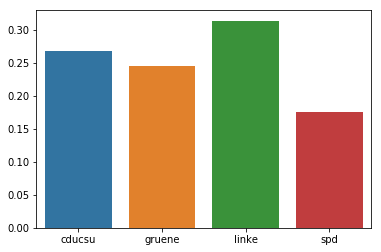

In [26]:
prediction = clf.predict_proba([readable_article])

print("Zeitungsartikel: {}".format(readable_title))

import seaborn as sns
%matplotlib inline
sns.barplot(clf.best_estimator_.steps[1][1].classes_, prediction.flatten())

In [ ]:
bow_vectors = clf.steps[0][1].transform(df.text)
idx2words = {k:v for v,k in clf.steps[0][1].vocabulary_.items()}
for party in np.unique(df['partei']):
    this_party = (df['partei'] == party).values * 2 - 1
    word_covariance = bow_vectors.T.dot(this_party).argsort()
    top_words = [idx2words[widx] for widx in word_covariance[-20:][::-1]]
    print("*********************\nPartei {} benutzt haeufig:\n{}".format(party, ", ".join(top_words)))

In [34]:
# Wir gruppieren nach Sprecher
grouped_by_speaker = df.groupby(['sitzung','wahlperiode','sprecher']).agg({'text':lambda x:" ".join(x), 'partei': lambda x:list(x)[0]})
# Erst nehmen wir einige Daten beiseite, um das Model darauf spaeter testen zu koennen
train_data, test_data, train_labels, test_labels = train_test_split(grouped_by_speaker['text'], grouped_by_speaker['partei'], test_size=0.3)
# Jetzt trainieren wir den Klassifier
clf_grouped_by_speaker = train(train_data, train_labels)
test_predictions = clf.predict(test_data)
report = classification_report(test_predictions, test_labels)
print(report)
print(confusion_matrix(test_labels, test_predictions))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1) ....
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1) ....
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 2) ....
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 2) ....
[CV]  clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.5072100313479624, total=  24.6s
[CV]  clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.5105982691584097, total=  27.1s
[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1) ...
[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1) ...
[CV]  clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 2), score=0.5311598746081505, total=  56.3s
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.5230094043887147, total=  27.6s
[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2) ...


[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:  1.6min remaining:  1.6min


[CV]  clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 2), score=0.5212592499686441, total=  54.4s
[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2) ...
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.5118525021949079, total=  27.3s
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2), score=0.5078369905956113, total=  52.0s
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2), score=0.4848864919101969, total=  50.4s


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.8min finished


Best parameters set found on development set:

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
  ...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

Grid scores on development set:

0.509 (+/-0.001) for {'clf__alpha': 1e-06, 'vect__max_df': 0.8, 'vect__ngram_range': (1, 1)}
0.526 (+/-0.002) for {'clf__alpha': 1e-06, 'vect__max_df': 0.8, 'vect__ngram_range': (1, 2)}
0.517 (+/-0.003) for {'clf__alpha': 0.0001, 'vect__max_df': 0.8, 'vect__ngram_range': (1, 1)}
0.496 (+/-0.006) for {'clf__alpha': 0.0001, 'vect__max_df': 0.8, 'vect__ngram_range': (1, 2)}

             precision    recall  f1-score   support

     cducsu       0.93      0.55      0.69      3783
     

/Users/felix/Code/Python/ml-schule/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


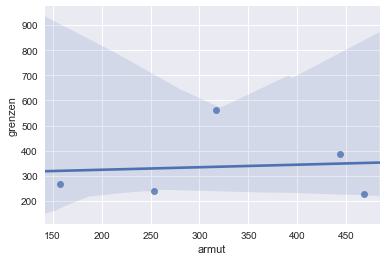

In [37]:
df['grenzen'] = df.text.str.lower().str.contains('grenzen')
df['armut'] = df.text.str.lower().str.contains('armut')
df_armut_sicherheit = df.groupby("partei").agg({'grenzen': sum, 'armut':sum})
import seaborn as sns; sns.set(color_codes=True)
%matplotlib inline
sns.regplot(x='armut', y='grenzen', data=df_armut_sicherheit)

In [76]:
df['timestamp'] = df.wahlperiode * 1000 + df.sitzung

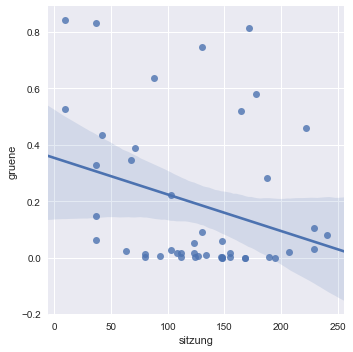

In [96]:
import seaborn as sns; sns.set(color_codes=True)
%matplotlib inline
sprecher = 'Jürgen Trittin'
sns.lmplot('sitzung','gruene',data=df[(df['sprecher']==sprecher) & (df['wahlperiode']==17)][['sitzung','gruene']])
